# Plot ice thickness observations

In [1]:
##Ben Pelto June 2019
###using this script to plot the thickness

# Python imports
import os
import pandas as pd
import salem
import numpy as np
import xarray as xr
import oggm
from oggm import cfg, utils, workflow, tasks, graphics
from oggm.workflow import execute_entity_task, gis_prepro_tasks, climate_tasks

##plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import pylab
def cm2inch(*tupl):### plots in cm ##frontiers 180 mm for full width, 85 mm half width (1 column) figures
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [2]:
num = 6 #num determines which gdir and gradient to use, refer to list below to select desired site

#data points gradients
grad = [6.84, 9.8, 7.11, 7.95, 10.84, 6.01, 7.92] # mm w.e. m-1 

srtm = [-1.58, -6.95, -6.47, -5.71, -5.86, -6.11, 0.48]
products_dir = '/home/pelto/Desktop/ice_thick/JoG/'
glacier = ['Kokanee', 'Haig', 'Conrad', 'Washmawapta', 'Illecillewaet', 'Nordic', 'Zillmer']

In [3]:
WORKING_DIR = utils.get_temp_dir('ice_thickness')
utils.mkdir(WORKING_DIR, reset=True)
cfg.initialize(logging_level='WORKFLOW')
cfg.PATHS['working_dir'] = WORKING_DIR

# cfg.PARAMS['use_rgi_area'] = False
cfg.PARAMS['border'] = 10

# Get the RGI glaciers for the run.
rgi_list = ['RGI60-02.00147', 'RGI60-02.01857', 'RGI60-02.02171', 'RGI60-02.03411', 'RGI60-02.03688'
            , 'RGI60-02.04264', 'RGI60-02.07780']

2020-05-20 21:10:59: oggm.cfg: Using configuration file: /home/pelto/anaconda2/envs/oggm_pub/lib/python3.7/site-packages/oggm/params.cfg
2020-05-20 21:10:59: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-05-20 21:10:59: oggm.cfg: Multiprocessing: using all available processors (N=8)
2020-05-20 21:11:05: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


In [4]:
rgidf = utils.get_rgi_glacier_entities(rgi_list) 
gdirs = workflow.init_glacier_directories(rgidf,from_prepro_level=1, prepro_border=10) 
# gdirs = workflow.init_glacier_regions(rgidf)
workflow.gis_prepro_tasks(gdirs)
workflow.climate_tasks(gdirs)
workflow.inversion_tasks(gdirs)
workflow.execute_entity_task(tasks.distribute_thickness_per_altitude, gdirs);
# gdir = gdirs[0]
# tasks.init_present_time_glacier(gdirs) 

2020-05-20 21:11:06: oggm.workflow: init_glacier_directories from prepro level 1 on 7 glaciers.
2020-05-20 21:11:06: oggm.workflow: Execute entity task gdir_from_prepro on 7 glaciers
2020-05-20 21:11:06: oggm.workflow: Execute entity task define_glacier_region on 7 glaciers
2020-05-20 21:11:07: oggm.workflow: Execute entity task glacier_masks on 7 glaciers
2020-05-20 21:11:07: oggm.workflow: Execute entity task compute_centerlines on 7 glaciers
2020-05-20 21:11:07: oggm.workflow: Execute entity task initialize_flowlines on 7 glaciers
2020-05-20 21:11:07: oggm.workflow: Execute entity task compute_downstream_line on 7 glaciers
2020-05-20 21:11:07: oggm.workflow: Execute entity task compute_downstream_bedshape on 7 glaciers
2020-05-20 21:11:07: oggm.workflow: Execute entity task catchment_area on 7 glaciers
2020-05-20 21:11:09: oggm.workflow: Execute entity task catchment_intersections on 7 glaciers
2020-05-20 21:11:09: oggm.workflow: Execute entity task catchment_width_geom on 7 glacier

In [5]:
shapefile = ['2017/Kokanee_17_final_WGS84_clip.shp', 'Haig/Haig_gpr_all_WGS84.shp', 'conrad_GPR_ALL_final_WGS84.shp', 
             'west_wash_data.shp', '2018/illec_may18_final_WGS84.shp', '2016/Nordic_2016_GPR_final_WGS84.shp', 
             'zillmer_GPR_All_final_WGS84.shp']
DF_Final=pd.DataFrame({'Glacier':[],'lat':[],'long':[],'depth':[],'x':[],'y':[]})
##illecillewaet radar data causes failure if using RGI polygon due to data bounds, so I clipped the radar data for now
for i in range(7):
    
    #df = df[i]
    df = salem.read_shapefile('/home/pelto/GIS/GPR/Data/' + shapefile[i])
    coords = np.array([p.xy for p in df.geometry]).squeeze()
    df['lon'] = coords[:, 0]
    df['lat'] = coords[:, 1]
    # df['lon'] = df[4]
    # df['lat'] = df[5]
    df = df[['lon', 'lat', 'depth']]
    # Convert the longitudes and latitudes to the glacier map projection:

    xx, yy = salem.transform_proj(salem.wgs84, gdirs[i].grid.proj, df['lon'].values, df['lat'].values)
    df['x'] = xx
    df['y'] = yy
    DF_Final=DF_Final.append({'Glacier':glacier[i],'lat':df['lat'],'long':df['lon'],'depth':df['depth'],'x':df['x'],'y':df['y']}, ignore_index=True)

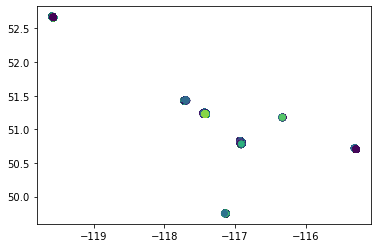

In [6]:
#plot these data
i=3
for i in range(7):
    geom = gdirs[i].read_shapefile('outlines')
#f, ax = plt.subplots()
    df=DF_Final[DF_Final.index==i]
    plt.scatter(x=df.long[i], y=df.lat[i], c=df.depth[i], cmap='viridis')#, s=10)#, ax=ax); #cmap='Blues',
#     geom.plot(ax=ax, facecolor='none', edgecolor='k');

In [7]:
import geopandas as gpd
shape=gpd.read_file("/home/pelto/GIS/outlines/ice_thick_glaciers.shp")
# shape

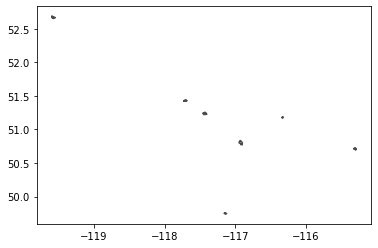

In [8]:
for i in np.arange(0,7,1):
    x,y=shape['geometry'][i].exterior.xy
    plt.plot(x,y,color='k',alpha=0.7)
plt.show()

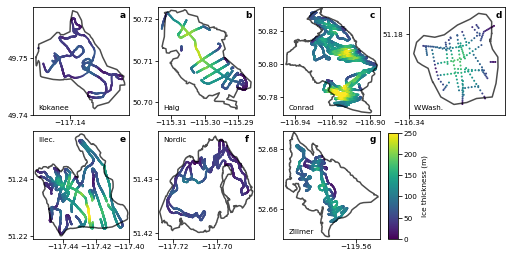

In [9]:
font = {'family' : 'Helvetica',
        'weight' : 'normal',
        'size'   : 7.25}
path = '/home/pelto/oggm_runs/products_opt/'
plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='1.5'; pylab.rcParams['ytick.major.pad']='1.5'
name = ['Kokanee', 'Haig', 'Conrad', 'W.Wash.', 'Illec.', 'Nordic', 'Zillmer']
fig, axarr = plt.subplots(2, 4, sharey=False, sharex=False,  figsize=(cm2inch(17.9, 8.9)))#figsize=(7,3.5))#(12, 6))
j, k = 0, 0
num=0
letter = ['a', 'b', 'c', 'd', 'e', 'f', 'g']

shape.sort_values('CenLat', inplace=True, ascending=True) #sort the shapefile objects by latitude
GIDX= shape.index # save an index of the shapefiles
count=0

for i in range(7):
       
    df=DF_Final[DF_Final.index==i]
    im = axarr[j, k].scatter(df.long[i], df.lat[i], c=df.depth[i], cmap='viridis', vmax=250, vmin=0, s=1.)    
#     axarr[j, k].set_title(glacier[i])
    
#     ds = xr.open_dataset(path + glacier[num] + '/' + glacier[num] + '101sw_MAE_optimized.nc') #101sw_ME
#     ds.attrs['pyproj_srs'] = ds.attrs['proj_srs'] #could try grid.proj
#     sm = ds.salem.get_map(cmap='viridis', vmin=0, vmax=250)#, vmax=250)
#     sm.set_data(ds.distributed_thickness)
#     sm.set_scale_bar(location=(0.85, 0.87),linewidth=1,ax=axarr[j, k],transform=axarr[j,k].transAxes) #fontsize=17)
#     Q = sm.visualize(ax=axarr[j,k], addcbar=False)
    
    x,y=shape['geometry'][GIDX[count]].exterior.xy
    axarr[j, k].plot(x,y,color='k',alpha=0.7)
    
    ymin = np.round(min(y),3) -0.001
    ymax = np.round(max(y),3) + 0.001
    xmin = np.round(min(x),3) -0.001
    xmax = np.round(max(x),3) + 0.001

    axarr[j, k].set_xlim(xmin, xmax )
    axarr[j, k].set_ylim(ymin, ymax )
#     axarr[j, k].set_xticks(np.round(np.arange(xmin, xmax, 0.02),2))
#     axarr[j, k].ticklabel_format(useOffset=False)
    axarr[1, 3].axis('off')
#     axarr[j, k].set_yticks(np.round(np.arange(ymin, ymax, 0.02),2))
    if count == 2 or count == 4 or count == 6:
        axarr[j,k].yaxis.set_major_locator(ticker.MultipleLocator(0.02))
    else:
        axarr[j,k].yaxis.set_major_locator(ticker.MultipleLocator(0.01))
        
    if count == 1: #or count == 3:
        axarr[j,k].xaxis.set_major_locator(ticker.MultipleLocator(0.01))
    else:
        axarr[j,k].xaxis.set_major_locator(ticker.MultipleLocator(0.02))
    if count == 6:
        axarr[j,k].xaxis.set_major_locator(ticker.MultipleLocator(0.04))
    axarr[j,k].text(0.9, 0.9, letter[count], transform=axarr[j,k].transAxes, fontweight='bold', fontsize=9)
    if count==4 or count==5:
        axarr[j,k].text(0.05, 0.9, name[count], transform=axarr[j,k].transAxes)
    else:
        axarr[j,k].text(0.05, 0.05, name[count], transform=axarr[j,k].transAxes)
    count+=1  # work through the index
    
    k += 1

    if i == 3: #changed to 2, 1 worked for 2x2 panel plot
        j += 1
        k = 0
    num+=1
fig.subplots_adjust(bottom=0.06, top=0.98, left=0.06, right=0.99, wspace=0.3, hspace=0.15) 

#Add an axes at position rect [left, bottom, width, height] where all quantities are in fractions of figure width and height
cb_ax = fig.add_axes([0.76, 0.06, 0.02, 0.42]) 
cbar = fig.colorbar(im, cax=cb_ax, label='Ice thickness (m)')
          
# plt.colorbar(im, pad=0.00, label='Ice thickness (m)')  
# plt.tight_layout(pad=0)
plt.savefig(products_dir + 'ice_thickness_all_names.pdf', dpi=300) 